In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from pyunicorn.timeseries import RecurrencePlot
import iberoSignalPro.preprocesa as ib
import ntwktools as nt

import logging
logging.basicConfig(level=logging.CRITICAL)

In [126]:
FILE_NAME = r"RIGHTemgFMM0315.csv"
data = pd.read_csv(FILE_NAME)

channel_1 = data["ch1"].values
channel_2 = data["ch7"].values


<Axes: >

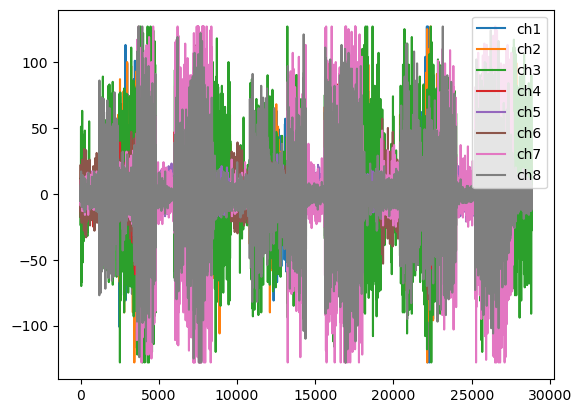

In [127]:
data.plot()

In [128]:
env1 = ib.obtenerEnvolvente(channel_1, "rms", 100)
env2 = ib.obtenerEnvolvente(channel_2, "rms", 100)


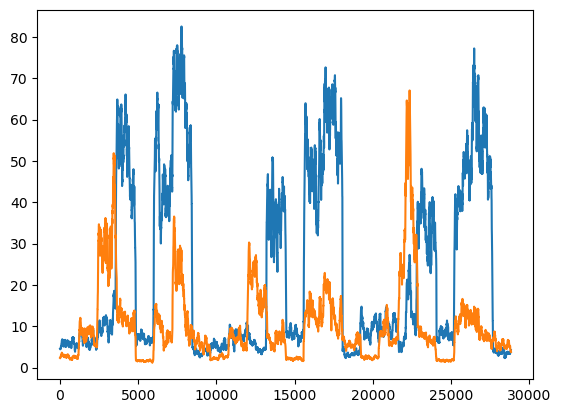

In [129]:
plt.plot(env2)
plt.plot(env1)


In [130]:
data = np.array([env2, env1])
data.shape

(2, 28817)

In [131]:
from scipy.spatial import distance
import rqatools as rqt
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

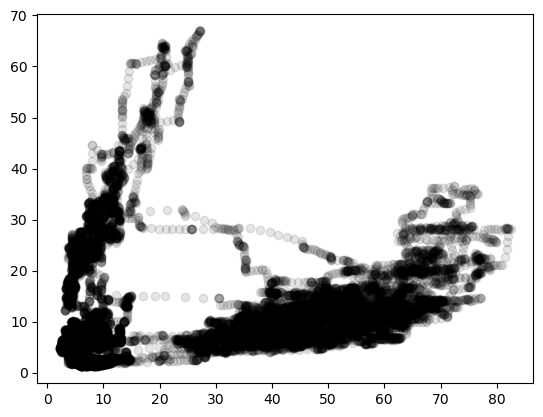

In [132]:
plt.scatter(data[0, :], data[1, :], color  = "black", alpha=0.1)



In [175]:
n_features = data.shape[0]
n_initi_samples = 10
init_data = np.zeros((n_initi_samples, n_features))

promedios = []

for i, row in enumerate(data.T):
    if i < n_initi_samples:
        init_data[i, :] = row
        if i == n_initi_samples - 1:
            gmm = GaussianMixture(n_components=4, covariance_type='spherical', random_state=42)
            gmm.fit(init_data)
            mus = gmm.means_
            sigmas = gmm.covariances_
            pis = gmm.weights_

    else:
        
        promedios.append(mus)
    
promedios = np.array(promedios)

c:\Users\fercy\miniconda3\envs\ibero\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



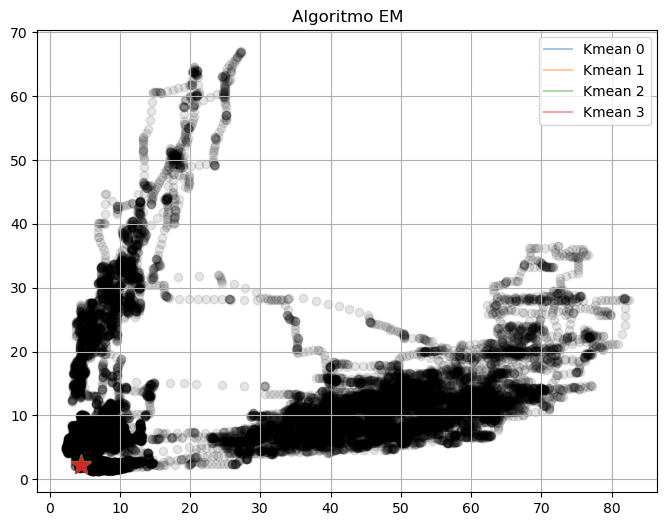

In [177]:
plt.figure(figsize=(8,6))
plt.scatter(data[0, :], data[1, :], color  = "black", alpha=0.1)



for i in range(4):
    plt.plot(promedios[:, i, 0], promedios[:, i, 1], label=f'Kmean {i}', alpha = 0.4)
    plt.scatter(promedios[-1, i, 0], promedios[-1, i, 1], marker='*', s=200)

plt.legend()
plt.title('Algoritmo EM')
plt.grid(True)
plt.show()

In [181]:
order = 5

n_initi_samples = 5
init_data = np.zeros((n_initi_samples, n_features))

promedios = []
k = 4

for i, row in enumerate(data.T):
    if i < n_initi_samples:
        init_data[i, :] = row
        if i == n_initi_samples - 1:
            centroids = init_data[np.random.choice(init_data.shape[0], k, replace=False)]
    else:
        centroids= rqt.K_means_estimation(row, k=k, centroids=centroids, alpha=0.001)
        promedios.append(centroids)
        
promedios = np.array(promedios)


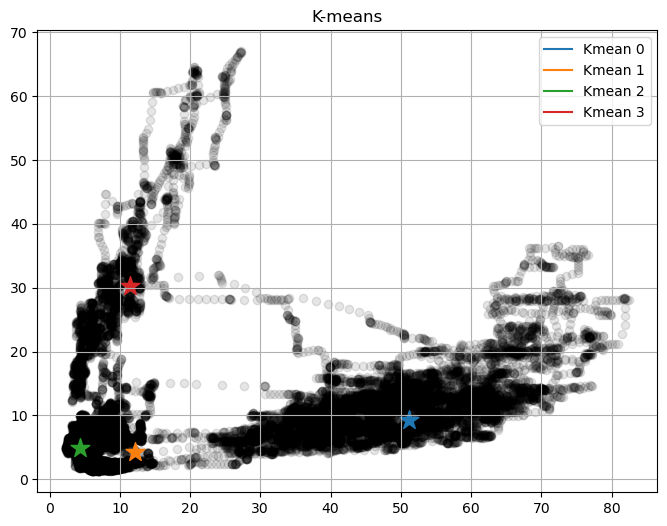

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(data[0, :], data[1, :], color  = "black", alpha=0.1)


for i in range(k):
    plt.plot(promedios[0:, i, 0], promedios[0:, i, 1], label=f'Kmean {i}', alpha = 1)
    plt.scatter(promedios[-1, i, 0], promedios[-1, i, 1], marker='*', s=200)

plt.legend()
plt.title('K-means')
plt.grid(True)
plt.show()

# SOM

In [166]:
order = 6

n_initi_samples = 5
init_data = np.zeros((n_initi_samples, n_features))

history_weights = []
k = 2

n_neurons = 4

weights = np.zeros((n_neurons, n_features))

weights[1] += 0.8


alpha_0 = 0.08
sigma_0 = 3.0
tau_alpha = 1000  # controla qué tan rápido decae alpha
tau_sigma = 1000  # controla qué tan rápido decae sigma


for iteration, row in enumerate(data.T):
    
    # Actualizar alpha y sigma con decaimiento exponencial
    alpha = alpha_0 * np.exp(-iteration / tau_alpha)
    sigma = sigma_0 * np.exp(-iteration / tau_sigma)

    # Actualizar pesos del SOM
    weights = rqt.SOM_estimation(row, n_neurons=n_neurons, alpha=alpha, sigma=sigma, weights=weights)

        
    history_weights.append(weights.copy())

    # Convertimos historia a array
history_weights = np.array(history_weights)  # shape: (steps, n_neurons, input_dim)




In [189]:
history_weights.shape

(28817, 4, 2)

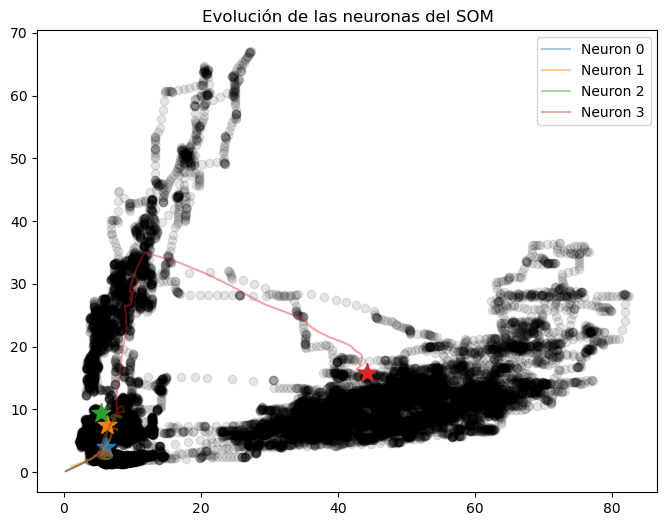

In [167]:
plt.figure(figsize = (8, 6))

plt.scatter(data[0, :], data[1, :], color  = "black", alpha=0.1)

for i in range(n_neurons):
    plt.plot(history_weights[:, i, 0], history_weights[:, i, 1], label=f'Neuron {i}', alpha = 0.4)
    plt.scatter(history_weights[-1, i, 0], history_weights[-1, i, 1], marker='*', s=200)

plt.title("Evolución de las neuronas del SOM")
plt.legend()
plt.grid(False)
plt.show()
